**Разработка модели персонализации предложения постоянным клиентам для интернет-магазина «В один клик»**

**Описание проекта:**


Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты.


Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

Отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**План проекта:**

Решать задачу нужно в четыре этапа:

1. [Выполнить предобработку данных.](#section2)
<a href='#section2'></a>


2. Провести [исследовательский](#section3) и [корреляционный](#section5) анализ данных.
<a href='#section3'></a>
<a href='#section5'></a>


3. [Разработать модель](#section6), которая предскажет вероятность снижения покупательской активности.
<a href='#section6'></a>


4. [Выделить сегмент покупателей](#section8), проанализировать его и предложить, как увеличить его покупательскую активность.
<a href='#section8'></a>

### Библиотеки и окружение

In [ ]:
!pip install matplotlib==3.8.4 -q

In [ ]:
!pip install scikit-learn==1.4.0 -q

In [ ]:
pip install phik==0.12.4 -q

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install shap==0.45.1 -q

In [ ]:
!pip install seaborn==0.13.2 -q

In [ ]:

import math

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [ ]:
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import shap

In [ ]:
pd.set_option('display.max_columns', None)

## Загрузка данных


In [ ]:
df_file = pd.read_csv('/datasets/market_file.csv')
df_market_money = pd.read_csv('/datasets/market_money.csv')
df_time = pd.read_csv('/datasets/market_time.csv')
df_money = pd.read_csv('/datasets/money.csv', sep=';')

### Проверка данных в таблицах на соответствие описанию.

**Описание данных**
- **market_file.csv**

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

    -id — номер покупателя в корпоративной базе данных.
    
    -Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    
    -Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    
    -Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    
    -Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    
    -Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    
    -Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    
    -Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    
    -Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    
    -Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    
    -Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    
    -Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    
    -Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
    
- **market_money.csv**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
    
    -id — номер покупателя в корпоративной базе данных.
    
    -Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    
    -Выручка — сумма выручки за период.
    
- **market_time.csv**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
    
    -id — номер покупателя в корпоративной базе данных.
    
    -Период — название периода, во время которого зафиксировано общее время.
    
    -минут — значение времени, проведённого на сайте, в минутах.
    
- **money.csv**

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
    
    -id — номер покупателя в корпоративной базе данных.
    
    -Прибыль — значение прибыли.

In [ ]:
df_file.head()


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [ ]:
df_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [ ]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [ ]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [ ]:
df_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [ ]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [ ]:
df_money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [ ]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


### Вывод:
Данные соответствуют описанию. Пропусков в данных не обнаружено.

Необходимо исправить в датасете df_money столбец 'Прибыль'

<a id='section2'></a>
## Предобработка данных

In [ ]:
def check(row):
    col = row.columns
    dupli = row.duplicated().sum()
    print('Количество явных дубликатов:', dupli)
    if dupli > 0:
        print(row.duplicated())
    for col_l in col:
        print('-'* 30)
        print('Уникальные значения:', col_l, row[col_l].sort_values().unique())
        #print('Количество дубликатов:', row.duplicated().sum())

### df_file

In [ ]:
check(df_file)

Количество явных дубликатов: 0
------------------------------
Уникальные значения: id [215348 215349 215350 ... 216645 216646 216647]
------------------------------
Уникальные значения: Покупательская активность ['Прежний уровень' 'Снизилась']
------------------------------
Уникальные значения: Тип сервиса ['премиум' 'стандарт' 'стандартт']
------------------------------
Уникальные значения: Разрешить сообщать ['да' 'нет']
------------------------------
Уникальные значения: Маркет_актив_6_мес [0.9 1.4 1.5 1.7 2.4 2.6 2.7 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9
 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7
 5.8 5.9 6.1 6.3 6.6]
------------------------------
Уникальные значения: Маркет_актив_тек_мес [3 4 5]
------------------------------
Уникальные значения: Длительность [ 110  121  125  129  131  132  133  134  135  136  140  142  145  147
  148  149  150  151  152  153  154  157  159  160  161  162  163  165
  166  167  168  169  170  171  175  176  177 

In [ ]:
# Проверим является ли данная категория ошибкой
df_file.loc[df_file['Тип сервиса'] == 'стандартт']

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5
10,215358,Снизилась,стандартт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4
400,215748,Прежний уровень,стандартт,нет,4.3,4,534,0.18,Кухонная посуда,3,1,4,10


10 строк с типом стандартт, явная опечатка

In [ ]:
df_file['Тип сервиса'] = df_file['Тип сервиса'].str.replace('стандартт', 'стандарт').astype('object')

In [ ]:
df_file.duplicated().sum()

0

### df_market_money

In [ ]:
check(df_market_money)

Количество явных дубликатов: 0
------------------------------
Уникальные значения: id [215348 215349 215350 ... 216645 216646 216647]
------------------------------
Уникальные значения: Период ['предыдущий_месяц' 'препредыдущий_месяц' 'текущий_месяц']
------------------------------
Уникальные значения: Выручка [     0.    2758.7   2890.  ...   7605.3   7799.4 106862.2]


In [ ]:
df_market_money.loc[df_market_money['Период'] == 'препредыдущий_месяц']

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
6,215350,препредыдущий_месяц,4826.0
11,215351,препредыдущий_месяц,4793.0
13,215352,препредыдущий_месяц,4594.0
...,...,...,...
3885,216643,препредыдущий_месяц,4704.0
3890,216644,препредыдущий_месяц,5299.0
3893,216645,препредыдущий_месяц,5334.0
3895,216646,препредыдущий_месяц,4725.0


Треть датасета, очевидно, что риск опечатки минимален. Исправим синтаксис.

In [ ]:
df_market_money['Период'] = df_market_money['Период'].str.replace('препредыдущий_месяц',
                                                                  'пред_предыдущий_месяц').astype('object')

### df_time

In [ ]:
check(df_time)

Количество явных дубликатов: 0
------------------------------
Уникальные значения: id [215348 215349 215350 ... 216645 216646 216647]
------------------------------
Уникальные значения: Период ['предыдцщий_месяц' 'текущий_месяц']
------------------------------
Уникальные значения: минут [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [ ]:
df_time['Период'] = df_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц').astype('object')

### df_money

In [ ]:
df_money['Прибыль'] = df_money['Прибыль'].str.replace(',', '.').astype('float64')

In [ ]:
check(df_money)

Количество явных дубликатов: 0
------------------------------
Уникальные значения: id [215348 215349 215350 ... 216645 216646 216647]
------------------------------
Уникальные значения: Прибыль [0.86 0.98 1.06 1.08 1.33 1.37 1.38 1.39 1.4  1.48 1.54 1.55 1.57 1.63
 1.64 1.68 1.81 1.82 1.83 1.84 1.87 1.92 1.95 1.97 2.   2.02 2.03 2.07
 2.08 2.09 2.1  2.11 2.13 2.15 2.16 2.18 2.19 2.21 2.23 2.24 2.26 2.27
 2.29 2.32 2.33 2.34 2.35 2.36 2.37 2.38 2.39 2.41 2.42 2.43 2.44 2.45
 2.46 2.47 2.48 2.49 2.5  2.51 2.53 2.54 2.55 2.57 2.59 2.6  2.61 2.63
 2.64 2.66 2.67 2.68 2.69 2.7  2.71 2.72 2.73 2.74 2.75 2.76 2.77 2.78
 2.79 2.8  2.81 2.82 2.83 2.84 2.85 2.86 2.87 2.88 2.9  2.91 2.92 2.93
 2.94 2.95 2.96 2.97 2.98 2.99 3.   3.01 3.03 3.04 3.05 3.06 3.07 3.08
 3.09 3.1  3.11 3.12 3.13 3.14 3.15 3.16 3.17 3.18 3.19 3.2  3.21 3.22
 3.23 3.24 3.25 3.26 3.27 3.28 3.29 3.3  3.31 3.32 3.33 3.34 3.35 3.36
 3.37 3.38 3.39 3.4  3.42 3.43 3.44 3.45 3.46 3.47 3.48 3.49 3.5  3.51
 3.52 3.53 3.54 3.55 3.56

### Вывод:


Испаравлены:
- df_file 'Тип сервиса' - 'стандартт' заменено на 'стандарт'.
- df_market_money 'Период' - препредыдущий_месяц' заменено на 'пред_предыдущий_месяц'.
- df_time 'Период' - 'предыдцщий_месяц' заменено на 'предыдущий_месяц'.
- df_money 'Прибыль' приведен к типу float64.


<a id='section3'></a>
## Исследовательский анализ данных


In [ ]:
def sign(row,column):
    if row.dtypes[column] == object:
        row[column].value_counts().plot.barh(figsize=(10, 5), grid= True)
        plt.title(column, fontsize=15)
        plt.ylabel('Количество')
        plt.rc('xtick', labelsize= 15 )
        plt.rc('ytick', labelsize= 15 )
        plt.show()
        one = pd.pivot_table(
            row,
            index=column,
            values = 'id',
            aggfunc='count')
        plt.title(column, fontsize=15)
        row[column].value_counts().plot(
            kind = 'pie',
            figsize=(10,10),
            autopct = '%0.01f%%',
            colors=sns.color_palette('Set2')
        )
        ax = plt.gca()
        #ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.show()
        one['% '] = round(one['id']/one['id'].sum()*100,2)
        one.rename(columns={'id':'количество'},
              inplace=True)
        return one

    else:
        fig, axes = plt.subplots(2, figsize=(15, 15), sharey='row')
        #axes[0].plot(row[column], kind='bar')
        axes[0].hist(row[column], bins=int(len(row) ** (0.5)))
        axes[0].grid(True)
        axes[0].set_title(column)
        axes[0].set_ylabel('Количество')
        axes[1].boxplot(data=row, x=column, vert=False, patch_artist=True)
        axes[1].grid(True)
        axes[1].set_xlabel(column)
        plt.show()
        return row[column].describe().T

### df_file

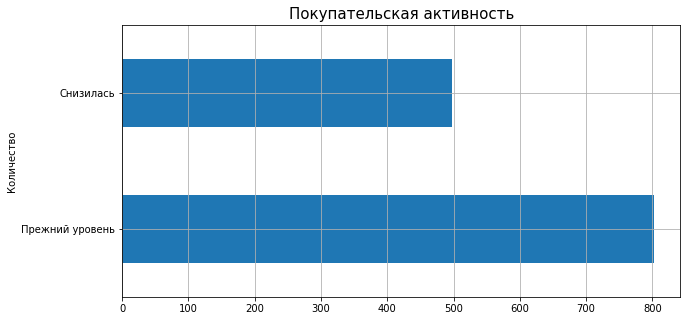

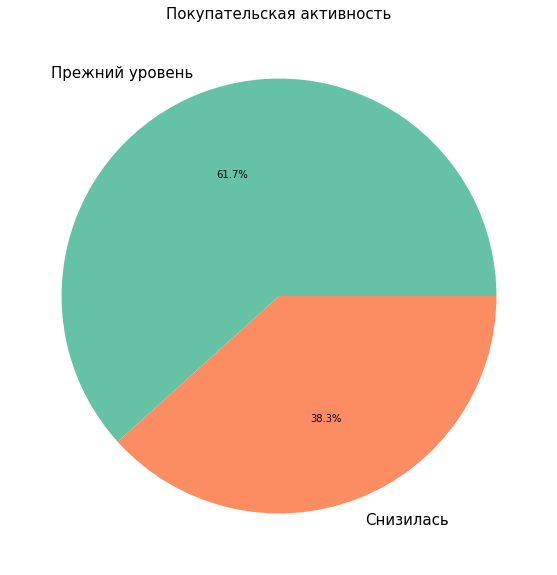

,количество,%
Покупательская активность,,
Прежний уровень,802,61.69
Снизилась,498,38.31


In [ ]:
sign(df_file,'Покупательская активность')

Большая часть клиентов имеют прежний уровень покупательской активности.

Наблюдается дисбаланс целевой переменной, при построении модели будет предпочтительнее производить стратификацию.

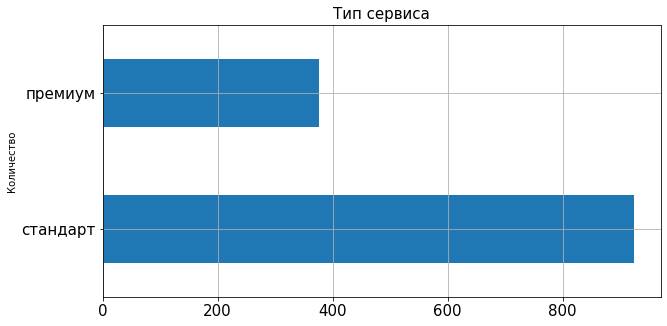

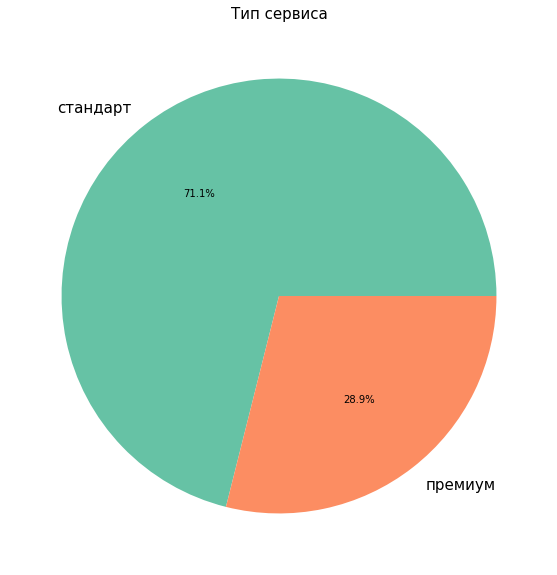

,количество,%
Тип сервиса,,
премиум,376,28.92
стандарт,924,71.08


In [ ]:
sign(df_file,'Тип сервиса')

Премиум подписка встречается редко.

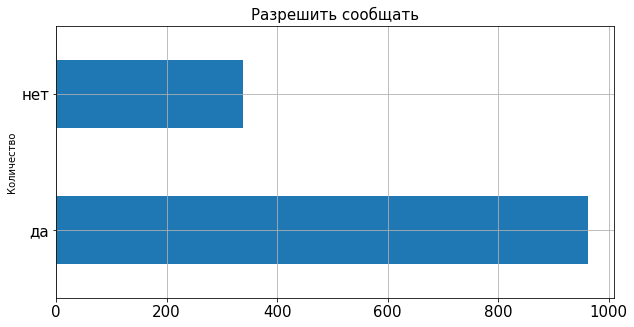

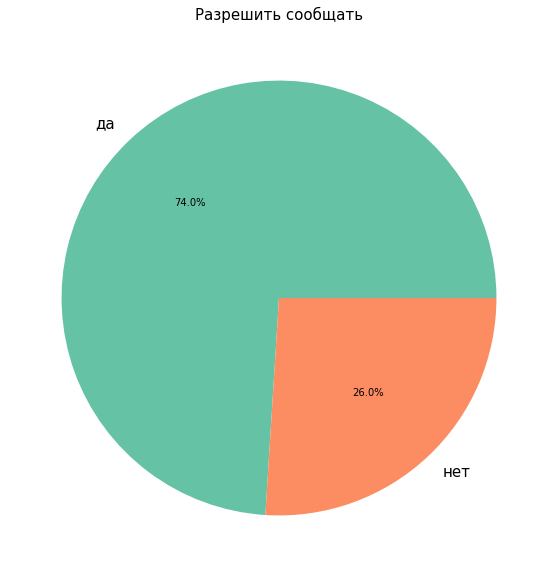

,количество,%
Разрешить сообщать,,
да,962,74.0
нет,338,26.0


In [ ]:
sign(df_file,'Разрешить сообщать')

Большинство пользователей дало разрешение присылать дополнительные предложения о товаре.

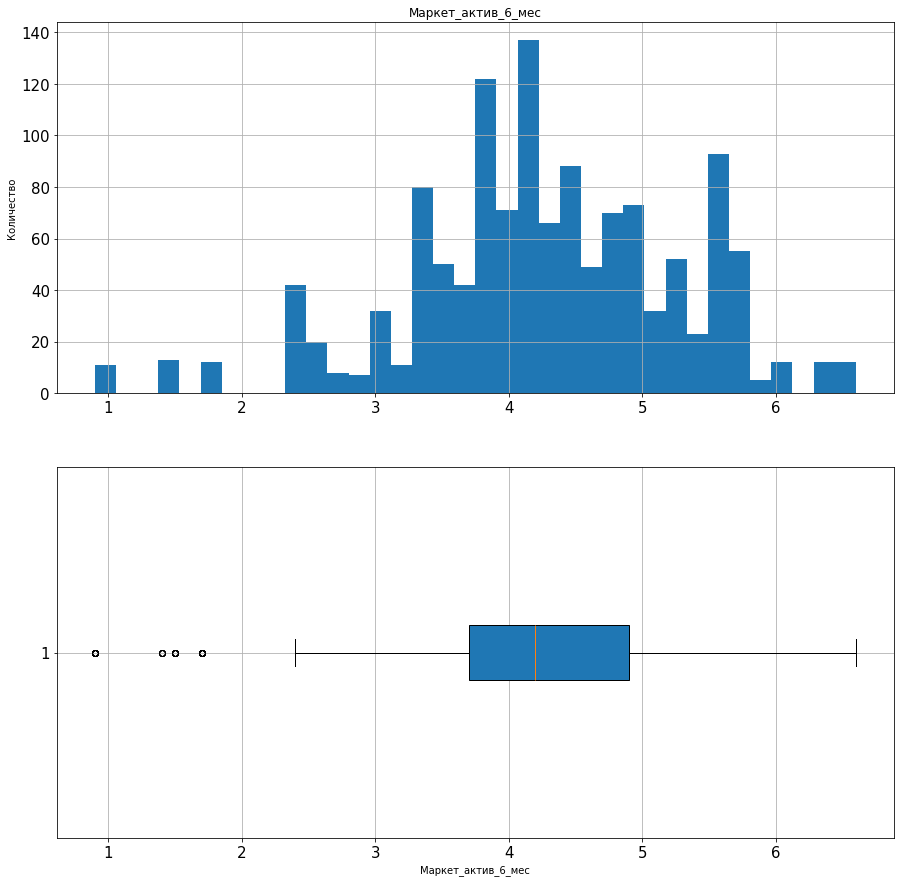

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

In [ ]:
sign(df_file,'Маркет_актив_6_мес')

Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
В среднем на клиента приходится 4 инструмента привлечения на платформу за 6 месяцев.


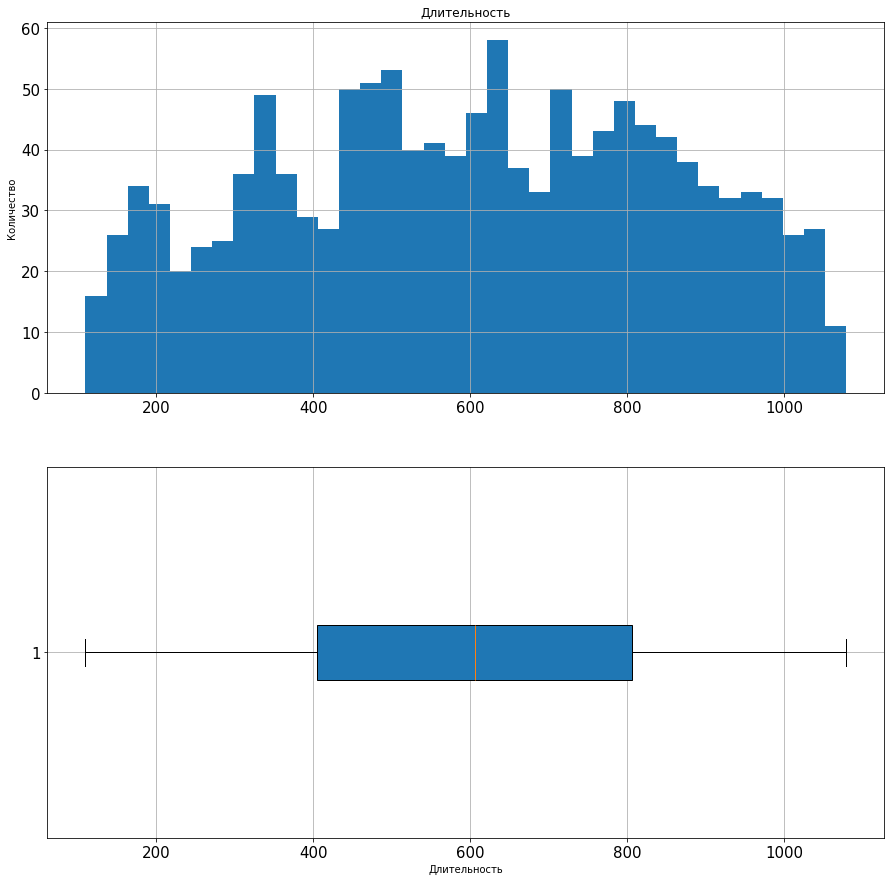

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

In [ ]:
sign(df_file,'Длительность')

Выбросов не обнаружено.

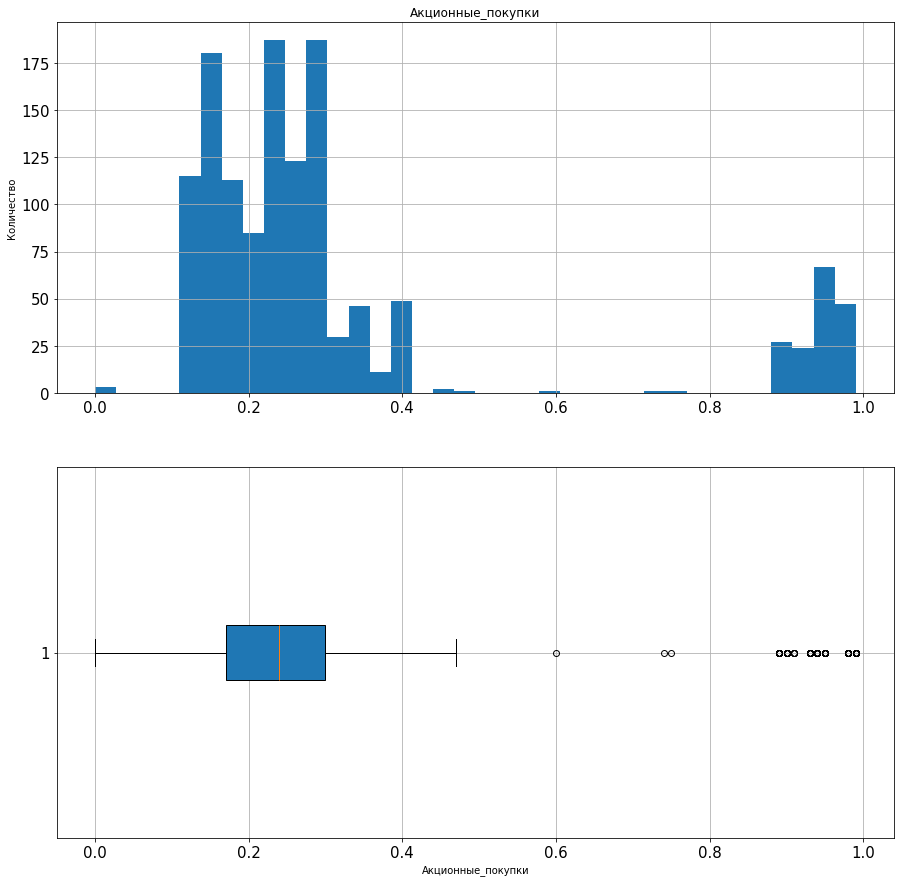

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

In [ ]:
sign(df_file,'Акционные_покупки')

Гитсограмма распределена скачками, есть некоторое сходство с категориальным признаком.

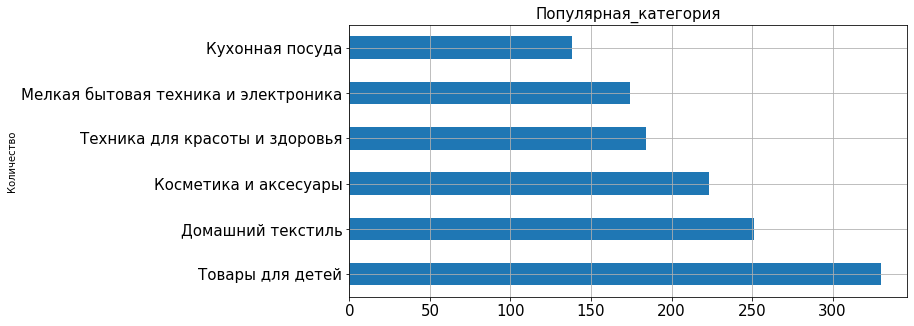

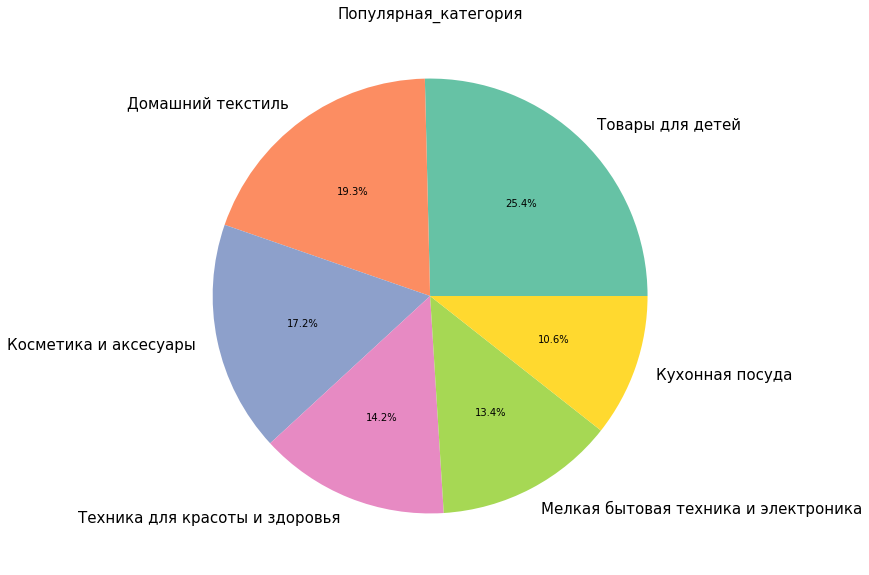

,количество,%
Популярная_категория,,
Домашний текстиль,251,19.31
Косметика и аксесуары,223,17.15
Кухонная посуда,138,10.62
Мелкая бытовая техника и электроника,174,13.38
Техника для красоты и здоровья,184,14.15
Товары для детей,330,25.38


In [ ]:
sign(df_file,'Популярная_категория')

Товары для детей - самая популярная категория, в то время как кухонная посуда самая маловостребованная.

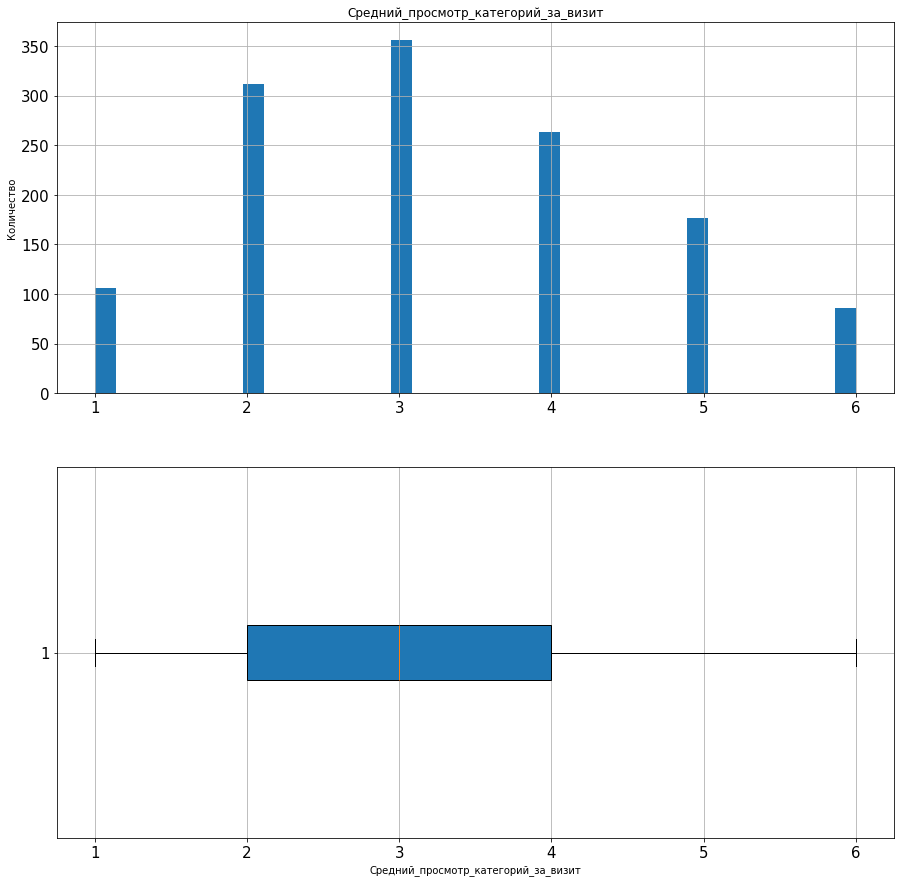

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

In [ ]:
sign(df_file,'Средний_просмотр_категорий_за_визит')

Признак категориальный. Норма просмотра от 2 до 4 категорий.

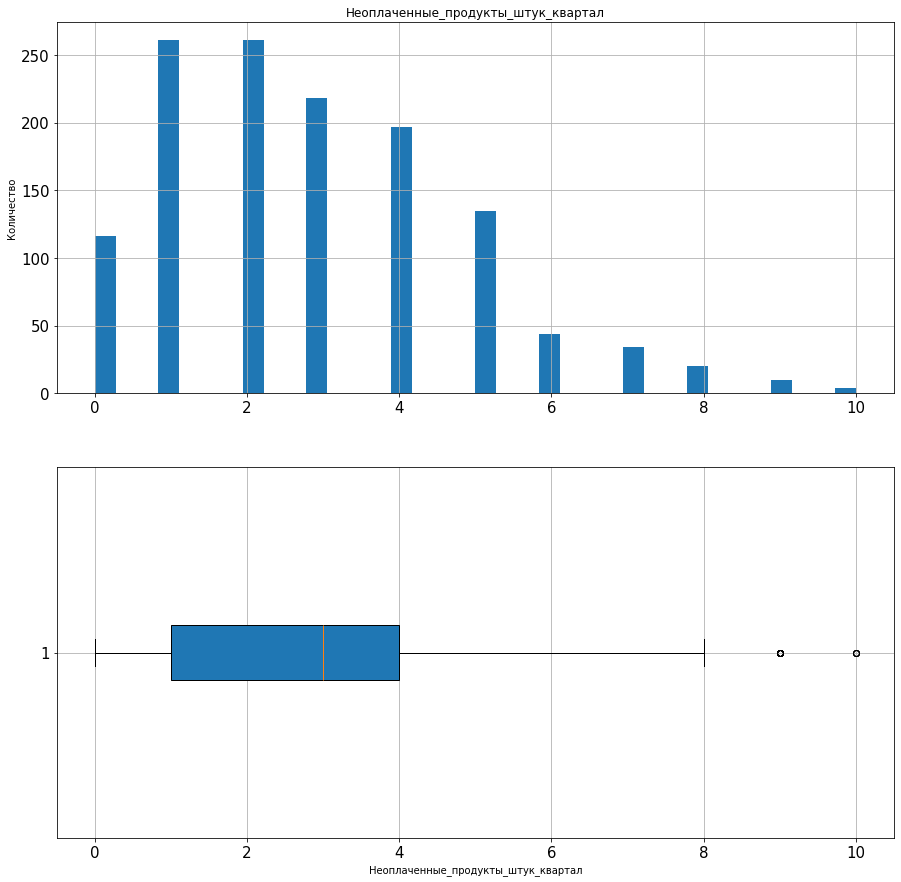

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

In [ ]:
sign(df_file,'Неоплаченные_продукты_штук_квартал')

В среднем клиенты не оплачивают 1-2 продуктов за квартал.

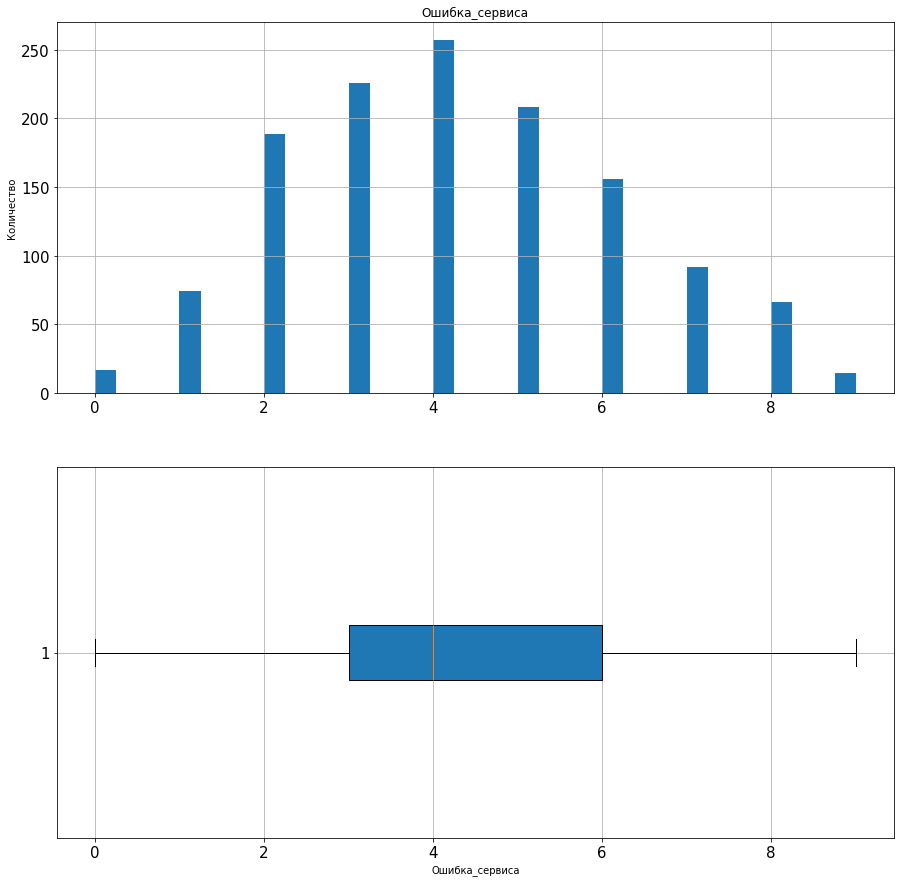

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: Ошибка_сервиса, dtype: float64

In [ ]:
sign(df_file,'Ошибка_сервиса')

В среднем пользователи сталкиваютя с 4 ошибкам сервиса.

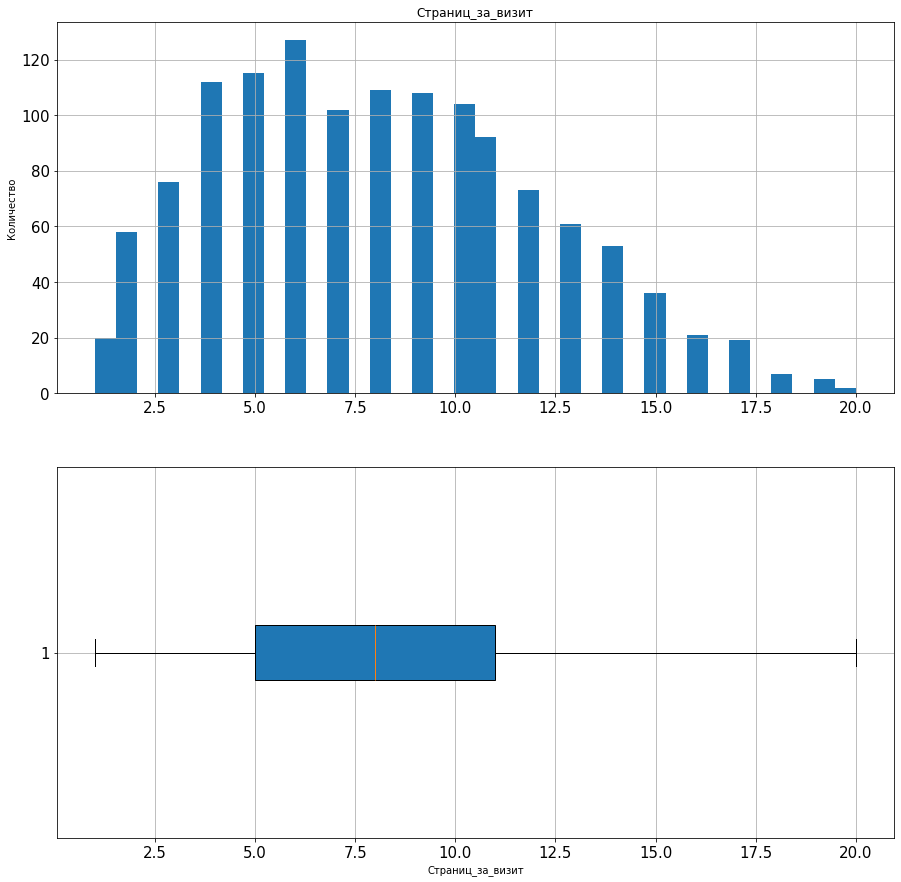

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: Страниц_за_визит, dtype: float64

In [ ]:
sign(df_file,'Страниц_за_визит')

Гистограмма имеет резкий спад после 10 страниц.

### df_market_money

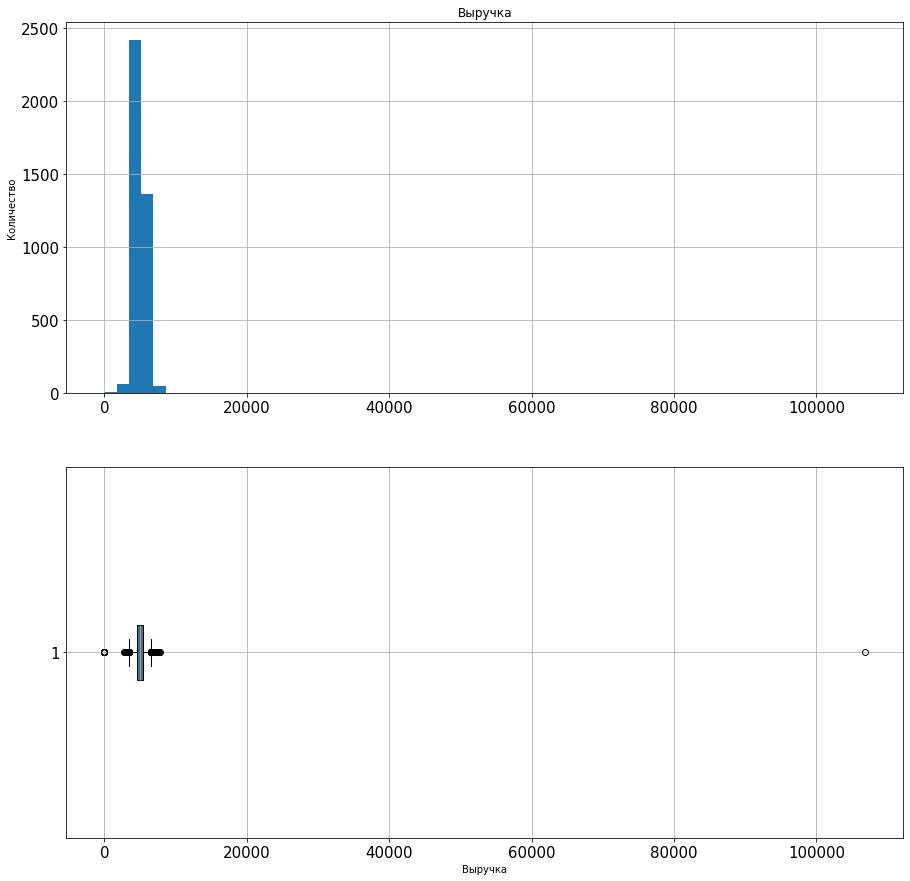

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

In [ ]:
sign(df_market_money,'Выручка')

In [ ]:
drop = df_market_money.loc[df_market_money['Выручка'] > 20000]
drop

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


Явный выброс

In [ ]:
df_market_money.drop(drop.index, inplace=True)

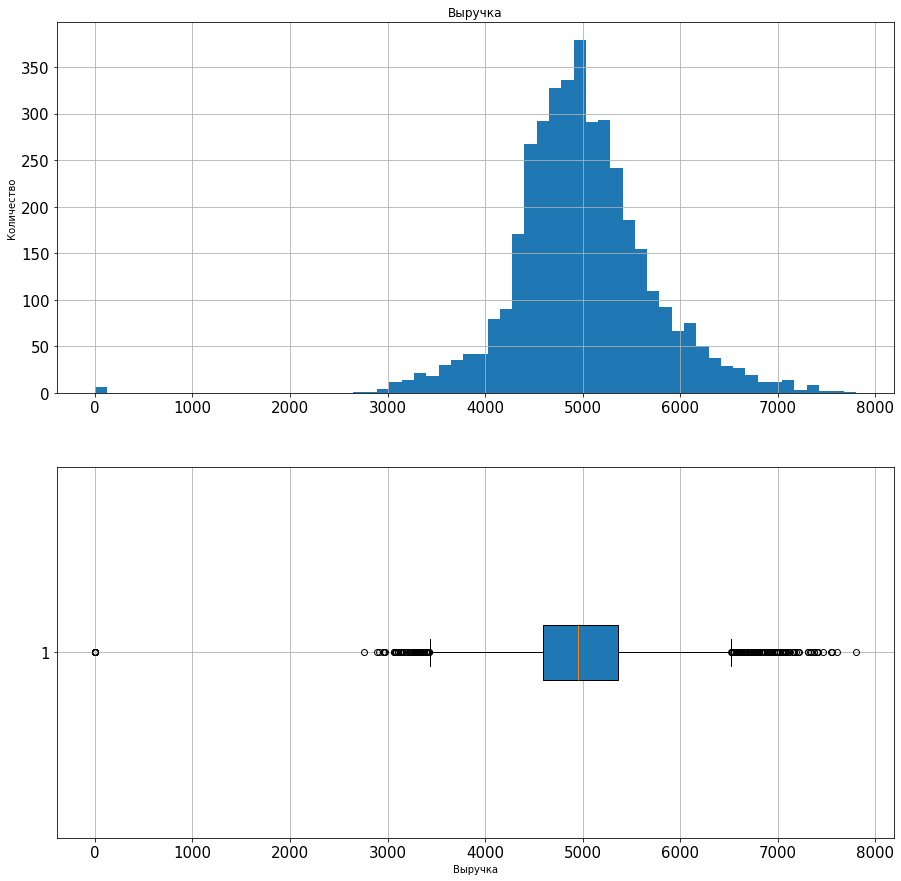

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: Выручка, dtype: float64

In [ ]:
sign(df_market_money,'Выручка')

Распределение гистограммы близко к  нормальному, выбросы - меньше 3350 и больше 6500. Наблюдаются нулевые значения.

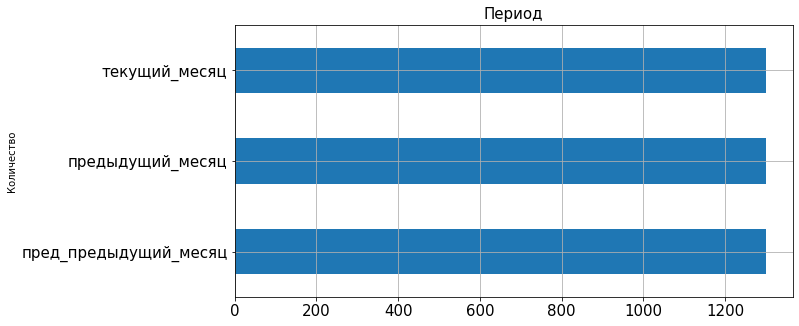

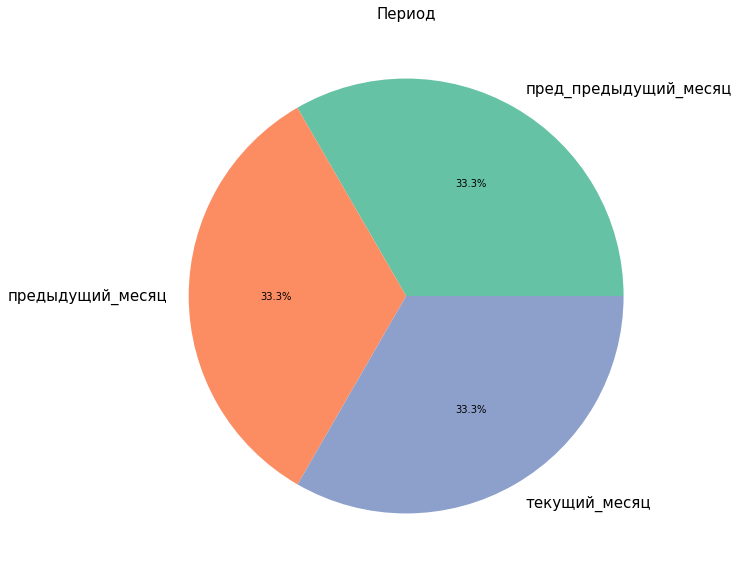

,количество,%
Период,,
пред_предыдущий_месяц,1300,33.34
предыдущий_месяц,1300,33.34
текущий_месяц,1299,33.32


In [ ]:
sign(df_market_money,'Период')

Доля каждого сегмента равна 1/3.

#### Отбор клиентов с покупательской активностью не менее трёх месяцев.

In [ ]:
df_market_money_pt = df_market_money.pivot_table(
    index= 'id',
    columns=['Период'],
    values=['Выручка']
)
df_market_money_pt.columns = [
    'выручка_пред_предыдущий_месяц',
    'выручка_предыдущий_месяц',
    'выручка_текущий_месяц'
]

In [ ]:
df_market_money_pt.head()

,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5


In [ ]:
df_to_drop = df_market_money_pt[(df_market_money_pt['выручка_пред_предыдущий_месяц']== 0)|
                                 (df_market_money_pt['выручка_предыдущий_месяц']== 0)|
                                 (df_market_money_pt['выручка_текущий_месяц']== 0)]

Сохраним в переменной чтобы в дальнейшем исключать из остальных таблиц клиентов по id.

In [ ]:
df_to_drop

,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
id,,,
215348,0.0,0.0,3293.1
215357,0.0,0.0,5986.3
215359,0.0,0.0,4735.0


In [ ]:
df_market_money_pt.drop(df_to_drop.index, inplace=True)

In [ ]:
df_market_money_pt

,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
id,,,
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5
215353,5124.0,4738.5,5388.5
...,...,...,...
216643,4704.0,3664.0,4741.7
216644,5299.0,4729.0,5353.0
216645,5334.0,5160.0,5139.2


### df_time

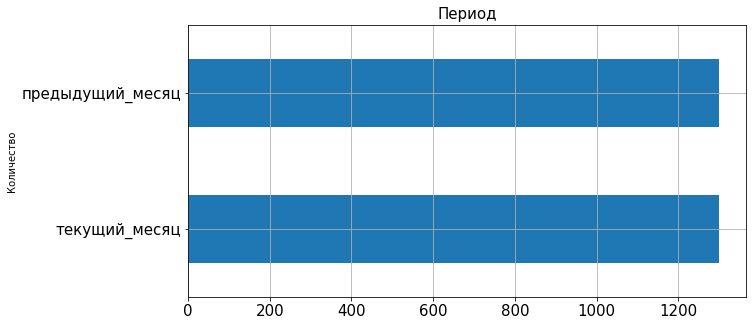

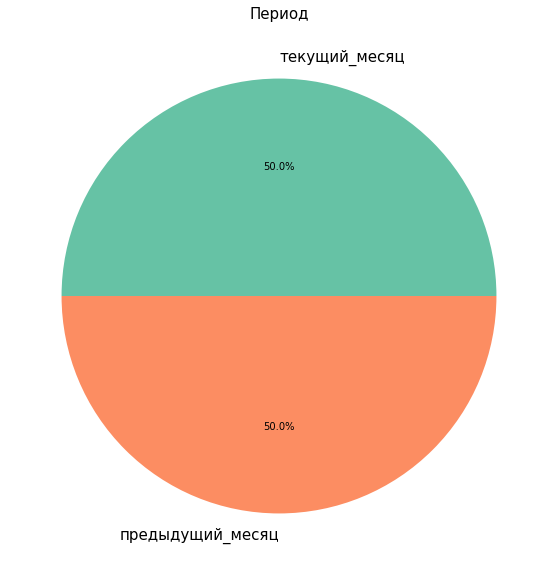

,количество,%
Период,,
предыдущий_месяц,1300,50.0
текущий_месяц,1300,50.0


In [ ]:
sign(df_time,'Период')

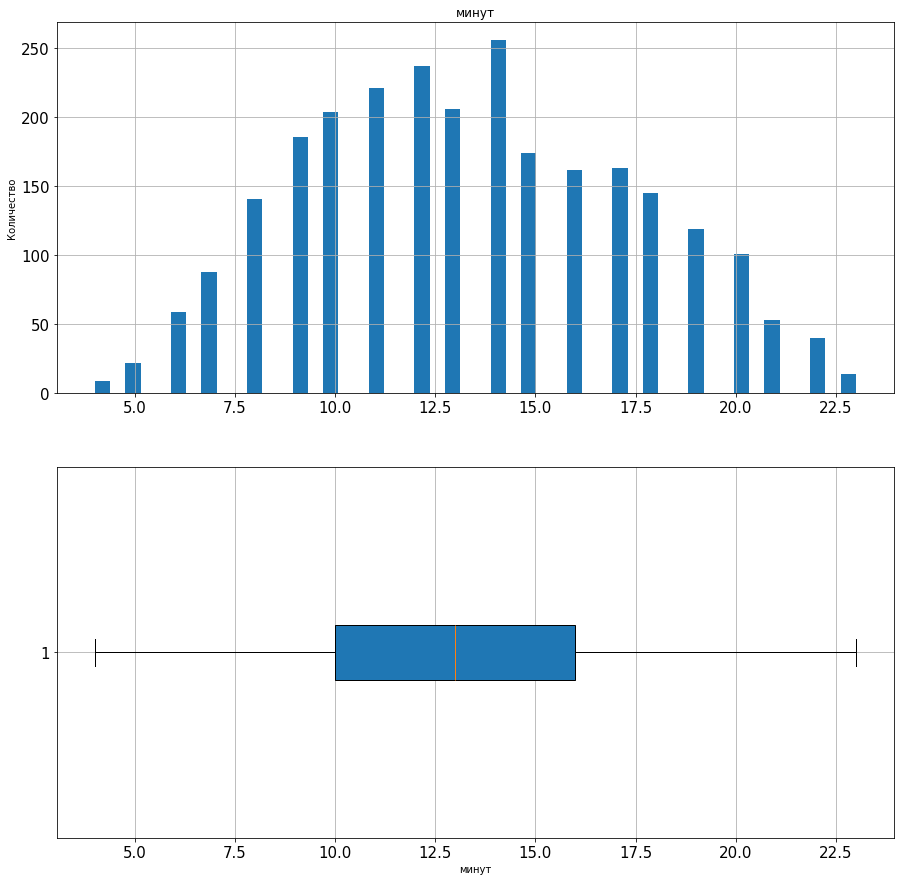

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

In [ ]:
sign(df_time,'минут')

В среднем пользователи проводят на платфороме 13 минут.

### df_money

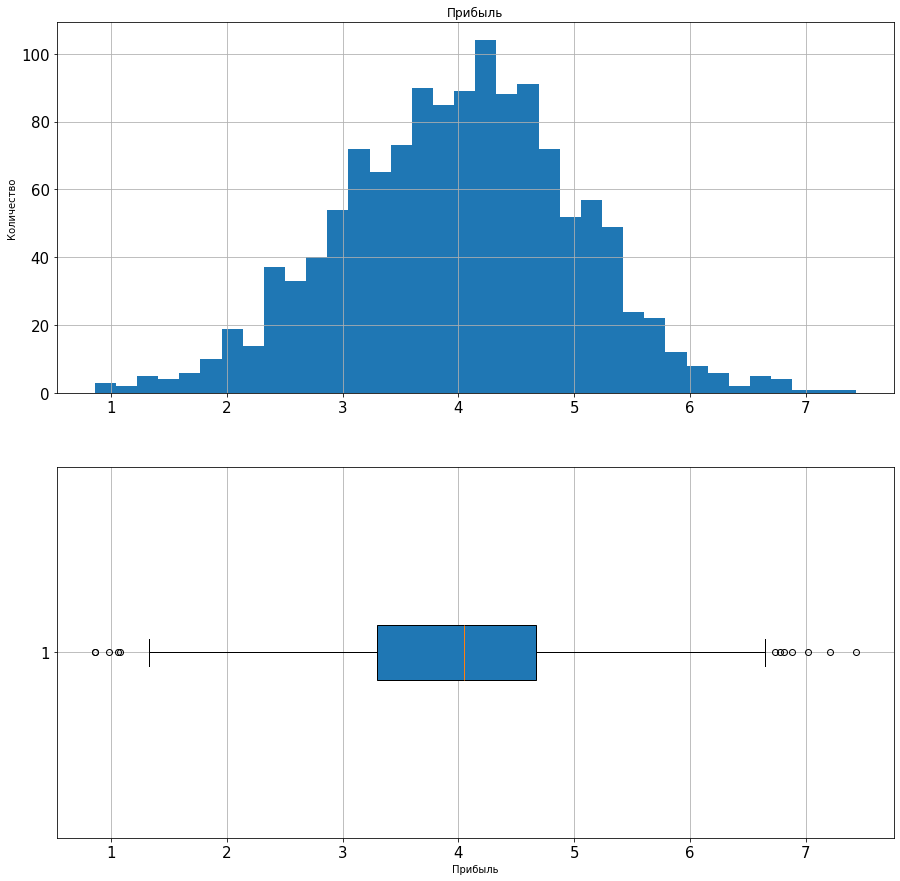

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: Прибыль, dtype: float64

In [ ]:
sign(df_money,'Прибыль')

Гистограмма имеет выбросы-хвосты в значениях меньше 1.2 и больше 6.75

### Вывод:

Удален:
- 1 строка df_market_money 'Выручка' > 20000, id сохранено в переменной drop


Создана таблица с покупательской активностью по трём месяцам, клиенты с меньшей активностью сохранены в переменной df_to_drop

По результатат исследования обнаружено:
- df_market_money 'Выручка' -  выбросы - меньше 3350 и больше 6500.
- df_money 'Прибыль' -  выбросы-хвосты в значениях меньше 1.2 и больше 6.75
- Акционные_покупки - можно отнести к категориальному признаку при построении модели.

## Объединение таблиц

In [ ]:
df_file = df_file.set_index('id')
df_time = df_time.set_index('id')
drop = drop.set_index('id')

Исключим клиентов без покупательской активности и клиента с выбросом в выручке.

In [ ]:
df_file.drop(df_to_drop.index, inplace=True)
df_time.drop(df_to_drop.index, inplace=True)
df_file.drop(drop.index, inplace=True)
df_time.drop(drop.index, inplace=True)
df_market_money_pt.drop(drop.index, inplace=True)

In [ ]:
df_time

,Период,минут
id,,
215349,текущий_месяц,10
215349,предыдущий_месяц,12
215350,текущий_месяц,13
215350,предыдущий_месяц,8
215351,текущий_месяц,13
...,...,...
216645,текущий_месяц,18
216646,предыдущий_месяц,18
216646,текущий_месяц,7


In [ ]:
df_time_pt = df_time.pivot_table(index= df_time.index, columns=['Период'], values=['минут'])
df_time_pt.columns = ['минут_предыдущий_месяц','минут_текущий_месяц']

In [ ]:
df_time_pt

,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13
215352,8,11
215353,10,10
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [ ]:
df_market_money_pt.head()

,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц
id,,,
215349,4472.0,5216.0,4971.6
215350,4826.0,5457.5,5058.4
215351,4793.0,6158.0,6610.4
215352,4594.0,5807.5,5872.5
215353,5124.0,4738.5,5388.5


In [ ]:
df = df_market_money_pt.join(df_time_pt)

In [ ]:
df.head()

,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,
215349,4472.0,5216.0,4971.6,12,10
215350,4826.0,5457.5,5058.4,8,13
215351,4793.0,6158.0,6610.4,11,13
215352,4594.0,5807.5,5872.5,8,11
215353,5124.0,4738.5,5388.5,10,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   выручка_пред_предыдущий_месяц  1296 non-null   float64
 1   выручка_предыдущий_месяц       1296 non-null   float64
 2   выручка_текущий_месяц          1296 non-null   float64
 3   минут_предыдущий_месяц         1296 non-null   int64  
 4   минут_текущий_месяц            1296 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 93.0 KB


In [ ]:
df = df_file.join(df)

In [ ]:
df.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Покупательская активность            1296 non-null   object 
 1   Тип сервиса                          1296 non-null   object 
 2   Разрешить сообщать                   1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Маркет_актив_тек_мес                 1296 non-null   int64  
 5   Длительность                         1296 non-null   int64  
 6   Акционные_покупки                    1296 non-null   float64
 7   Популярная_категория                 1296 non-null   object 
 8   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  Ошибка_сервиса                       1296 non-null   int64  
 11  Страниц_за_визит       

In [ ]:
df['id'] = df.index

In [ ]:
df = df.reset_index(drop=True)
df

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,id
0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,5216.0,4971.6,12,10,215349
1,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5457.5,5058.4,8,13,215350
2,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,6610.4,11,13,215351
3,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,5872.5,8,11,215352
4,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,4738.5,5388.5,10,10,215353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,4704.0,3664.0,4741.7,14,7,216643
1292,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,5299.0,4729.0,5353.0,12,11,216644
1293,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5334.0,5160.0,5139.2,12,18,216645
1294,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4725.0,4923.0,5224.6,18,7,216646


### Вывод:

Создана общая таблица с количеством строк 1296.

<a id='section5'></a>
## Корреляционный анализ

Целевой признак- покупательская активность.

Коэффициент корреляции Пирсона неприменим к категориальным данным. Через phik возможно применить теплокарту с корреляцией к категориальным признакам.

In [ ]:
phik_overview = (df.drop('id', axis=1).phik_matrix(verbose=False))


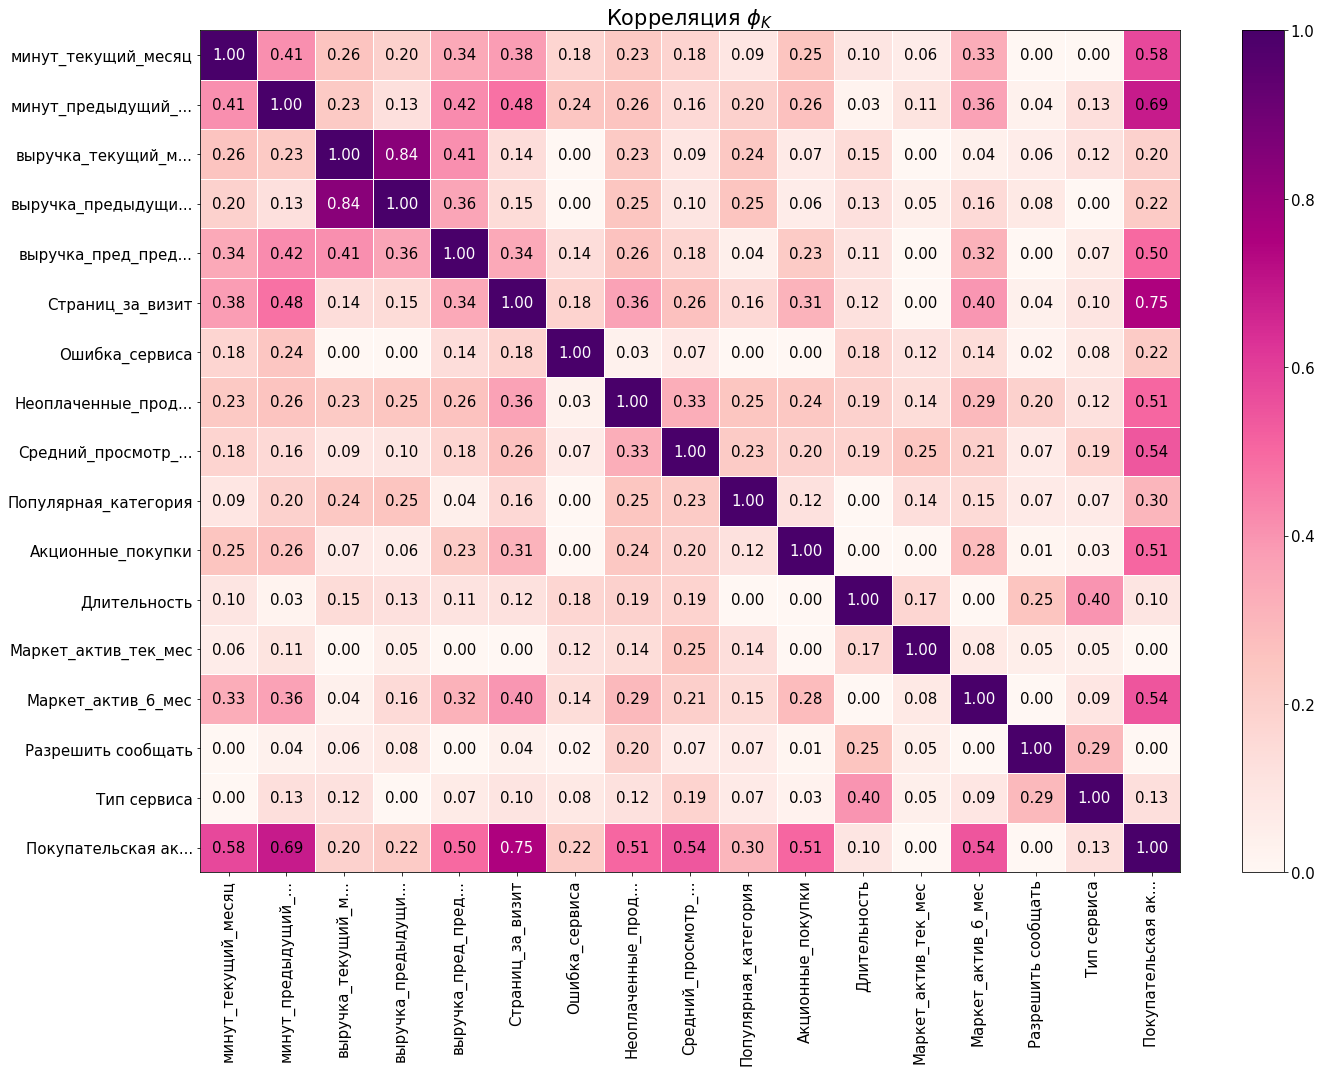

In [ ]:
matrix = np.triu(phik_overview .corr())
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='RdPu',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

### Вывод:

Оценка корреляции по шкале Чеддока, где:
- Очень слабая связь — от 0,1 до 0,3.

- Слабая связь — от 0,3 до 0,5.

- Средняя связь — от 0,5 до 0,7.

- Высокая связь — от 0,7 до 0,9.

- Очень высокая связь — от 0,9 до 1,0.


При оценке корреляции наблюдаем:
- Выручка текущий месяц - выручка предыдущий месяц: **высокая связь**.


- Покупательская активность - минут предыдущий месяц: средняя связь~высокая связь.


- Покупательская активность - минут текущий месяц: средняя связь.


- Покупательская активность - страниц за визит: **высокая связь**.


- Покупательская активность - выручка пред предыдущий месяц: средняя связь.


- Покупательская активность - неоплаченные продукты штук квартал: средняя связь.


- Покупательская активность - средний просмотр категорий за визит: средняя связь.


- Покупательская активность - акционные покупки: средняя связь.


- Покупательская активность - маркет актив 6 мес: средняя связь.

Мультиколлинеарности не обнаружено

<a id='section7'></a>
## Использование пайплайнов.


Для кодирования категориальных признаков используем как минимум два кодировщика:
- [x]   OneHotEncoder
- [x]   OrdinalEncoder


Для масштабирования количественных — как минимум два скейлера:
- [x]  MinMaxScaler
- [x]   StandardScaler


In [ ]:
num_columns = []
cat_columns = []
def types(row, col):
    columns = row.columns
    for column in columns:
        if column != col and column != 'id':
            if row.dtypes[column] == object:
                cat_columns.append(column)
            else:
                num_columns.append(column)
    return num_columns, cat_columns

In [ ]:
types(df, 'Покупательская активность')

(['Маркет_актив_6_мес',
  'Маркет_актив_тек_мес',
  'Длительность',
  'Акционные_покупки',
  'Средний_просмотр_категорий_за_визит',
  'Неоплаченные_продукты_штук_квартал',
  'Ошибка_сервиса',
  'Страниц_за_визит',
  'выручка_пред_предыдущий_месяц',
  'выручка_предыдущий_месяц',
  'выручка_текущий_месяц',
  'минут_предыдущий_месяц',
  'минут_текущий_месяц'],
 ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория'])

In [ ]:
# список для OneHotEncoder
ohe_columns = ['Популярная_категория']

# список для OrdinalEncoder
ord_columns = ['Разрешить сообщать', 'Тип сервиса']


In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train1, y_test1 = train_test_split(
    df.drop(['Покупательская активность', 'id'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность'])

le = LabelEncoder()

y_train = le.fit_transform(y_train1)

y_test = le.transform(y_test1)

labeled = pd.DataFrame(y_train, y_train1, columns=['LabelEncoder'])
print(X_train.shape, X_test.shape)
print(labeled.head())

(972, 16) (324, 16)
                           LabelEncoder
Покупательская активность              
Прежний уровень                       0
Снизилась                             1
Прежний уровень                       0
Прежний уровень                       0
Снизилась                             1


In [ ]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['да', 'нет'],
                    ['стандарт', 'премиум']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)


# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


### Четыре модели.

Остановимся на метрике roc-auc, так как она оценивает результаты работы модели в целом, таким образом не будет перетягивания значений между TP и TN и т.д.

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
      # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

        # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['rbf', 'sigmoid'],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

    },
]


### Выбор лучшей модели.


In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

y_test_pred = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
           

## Анализ важности признаков

### Оценка важности признаков с помощью метода SHAP.

In [ ]:
result = pd.DataFrame(randomized_search.cv_results_)
result = result[
    ['rank_test_score',
     'param_models',
     'mean_test_score',
     'params'
    ]
].sort_values('rank_test_score')
result

,rank_test_score,param_models,mean_test_score,params
4,1,"LogisticRegression(penalty='l1', random_state=...",0.898314,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,2,DecisionTreeClassifier(random_state=42),0.779687,"{'preprocessor__num': StandardScaler(), 'model..."
1,3,SVC(random_state=42),0.748321,"{'preprocessor__num': 'passthrough', 'models__..."
0,4,DecisionTreeClassifier(random_state=42),0.739011,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,5,DecisionTreeClassifier(random_state=42),0.728088,"{'preprocessor__num': StandardScaler(), 'model..."


In [ ]:
model = randomized_search.best_estimator_.named_steps['models']
model

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

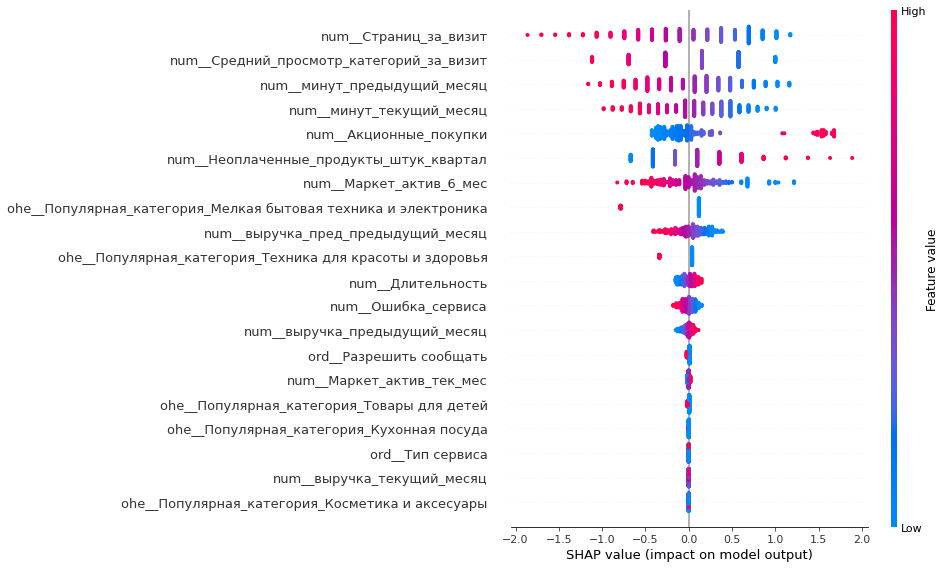

None

In [ ]:
X_train_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(model, X_train_new)

X_test_new = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_new = pd.DataFrame(X_test_new, columns=feature_names)
shap_values = explainer(X_test_new)

display(shap.plots.beeswarm(shap_values, max_display=30))



Акционные покупки сильно перетягивают значение к классу 1.


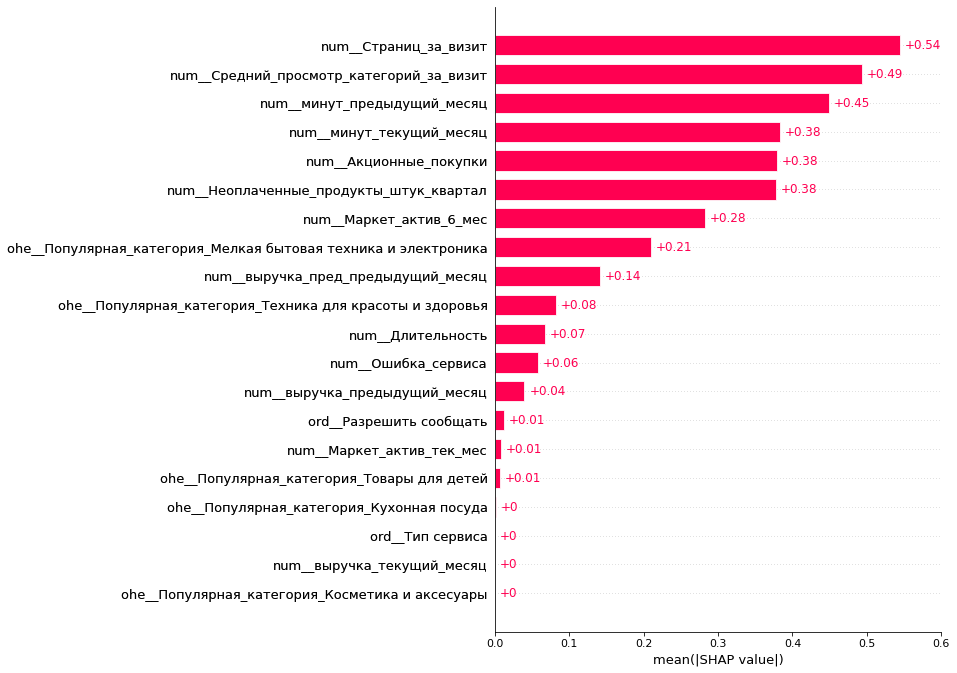

None

In [ ]:
display(shap.plots.bar(shap_values, max_display=30))

### Выводы о значимости признаков:
**Мало значимые для модели признаки:**
- Маркет_актив_текущий_месяц

- Разрешить_сообщать

- Маркет_актив_тек_месяц

- Популярная_категория_товары_для_детей

- Популярная_категория_кухонная_посуда

- Тип сервиса

- Выручка_текущий_месяц

- Популярная_категория_Косметика и аксессуары

**Признаки сильнее всего влияющие на целевой признак топ 6:**

- Страниц_за_визит

- Средний_просмотр_категорий_за_визит

- минут_предыдущий_месяц

- Минут_текущий_месяц

- Акционные_покупки

- Неоплаченные_продукты_штук_квартал

**Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений:**

- Пользователи, которые много времени провели онлайн предыдущий месяц могли планировать покупки, таким образом для корректности данных можно также получить информацию о частоте сохранения товаров в избранное.


- Пользователи, просматривающие много страниц и категорий за визит склонны к большим покупкам. Важно хорошо настроить систему предложений похожего товара или товара, косвенно относящегося к просматриваемой категории.


- Устойчивое внимание к платформе достигается простотой использования платформы, информативно будет отследить с какого момента у доли покупателей с постоянным устойчивым спросом происходит спад. Для этого можно отследить падения на датасете за больший период.


- Акционные покупки сильно влияют на продажи, необходимо рассмотреть системы скидок и предложений для просмотренных товаров и категорий. Если клиент вовремя не найдёт искомый товар он может преключиться на другую платформу.

<a id='section8'></a>
## Сегментирование.

Рассмотрим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

Используем таблицу с прибылью из датасета df_money

In [ ]:
y_pred = model.predict_proba(X_test_new)
X_test_seg = X_test.copy()
X_test_seg['y_yest'] = y_test.tolist()
X_test_seg['predict_proba'] = model.predict_proba(X_test_new)[:,1]

X_test_seg

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,y_yest,predict_proba
809,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,4912.0,3973.0,3289.2,16,17,0,0.013654
302,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,4656.0,3548.0,4170.7,11,9,1,0.984841
955,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,4565.0,5444.0,6335.8,20,11,0,0.113841
149,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,4993.0,6604.0,6758.7,9,9,1,0.756779
582,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,4451.0,5090.0,5773.8,15,18,1,0.521940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4,4488.0,3662.0,4158.6,11,10,1,0.950839
881,премиум,да,3.9,4,1048,0.21,Техника для красоты и здоровья,3,0,6,14,4553.0,4325.0,4257.4,15,17,0,0.050116
364,стандарт,да,2.4,4,952,0.30,Техника для красоты и здоровья,3,5,2,3,4165.0,3067.0,3343.9,13,14,1,0.841386
789,стандарт,нет,4.0,4,748,0.28,Косметика и аксесуары,4,0,4,9,4885.0,5660.5,6462.6,14,10,0,0.209048


In [ ]:
id_join = df['id']
X_test_seg = X_test_seg.join(id_join)

In [ ]:
X_test_seg = X_test_seg.set_index('id')
df_money = df_money.set_index('id')
X_test_seg = X_test_seg.join(df_money, how='left')


In [ ]:
X_test_seg

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,y_yest,predict_proba,Прибыль
id,,,,,,,,,,,,,,,,,,,
216161,стандарт,да,4.1,4,606,0.15,Техника для красоты и здоровья,6,1,4,12,4912.0,3973.0,3289.2,16,17,0,0.013654,4.69
215654,премиум,нет,1.4,4,684,0.94,Товары для детей,3,6,1,6,4656.0,3548.0,4170.7,11,9,1,0.984841,2.75
216307,премиум,да,3.3,4,488,0.13,Домашний текстиль,4,2,8,10,4565.0,5444.0,6335.8,20,11,0,0.113841,3.16
215501,премиум,да,3.5,3,1057,0.35,Домашний текстиль,4,3,5,6,4993.0,6604.0,6758.7,9,9,1,0.756779,3.74
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,4451.0,5090.0,5773.8,15,18,1,0.521940,4.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215429,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4,4488.0,3662.0,4158.6,11,10,1,0.950839,3.71
216233,премиум,да,3.9,4,1048,0.21,Техника для красоты и здоровья,3,0,6,14,4553.0,4325.0,4257.4,15,17,0,0.050116,4.62
215716,стандарт,да,2.4,4,952,0.30,Техника для красоты и здоровья,3,5,2,3,4165.0,3067.0,3343.9,13,14,1,0.841386,4.07


In [ ]:
def scat(row, column1, column2):
    hue_types = row.columns
    for hue_type in hue_types:
        if row.dtypes[hue_type] == object:
            plt.figure(figsize=(8, 5))
            sns.scatterplot(data=row, x = column2, y = column1, hue= hue_type)
            plt.ylabel(column1)
            plt.xlabel(column2)
            plt.legend(bbox_to_anchor=(1, 0.6))
            plt.title(f'Диаграмма рассеяния между\n {column2} и {column1} по категории {hue_type}',
                      fontsize=14,
                      fontweight="bold"
                     )
            plt.show()

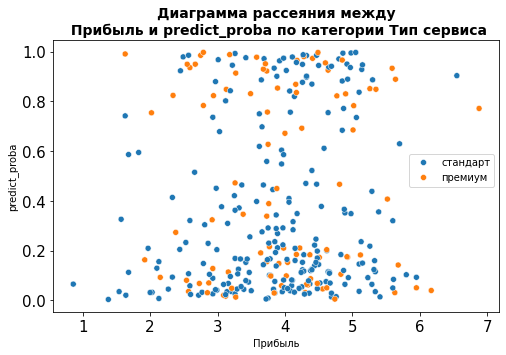

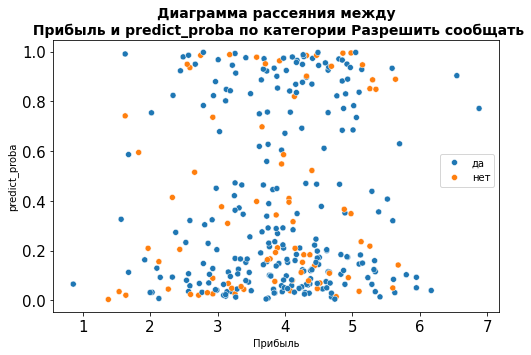

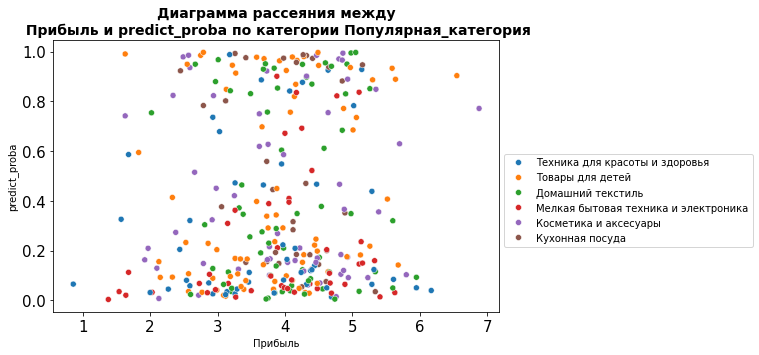

In [ ]:
scat(X_test_seg, 'predict_proba', 'Прибыль')

Среднее значение прибыли 3.99, медиана 4.045, будем ориентироваться по медиане, округлённой до целого числа - 4

In [ ]:
seg_low = X_test_seg[(X_test_seg['y_yest']==1)&(X_test_seg['Прибыль']>4)]
seg_low

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,выручка_пред_предыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,y_yest,predict_proba,Прибыль
id,,,,,,,,,,,,,,,,,,,
215934,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,4451.0,5090.0,5773.8,15,18,1,0.521940,4.40
215375,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4,4715.0,5253.5,5633.1,8,9,1,0.964518,4.18
215452,стандарт,да,3.8,4,756,0.90,Товары для детей,2,3,6,4,4963.0,4045.0,4206.2,11,10,1,0.944252,4.50
215484,премиум,нет,2.9,5,448,0.23,Товары для детей,4,2,6,3,4267.0,5059.0,5018.7,5,7,1,0.888760,5.64
215496,премиум,да,4.0,4,684,0.40,Техника для красоты и здоровья,1,6,2,4,4896.0,5020.0,5237.1,11,11,1,0.925242,4.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215668,премиум,да,4.4,4,343,0.94,Товары для детей,2,9,2,2,4723.0,5567.5,5293.2,6,9,1,0.996319,4.49
215356,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4433.0,4146.5,4566.4,6,7,1,0.889138,4.93
215651,стандарт,нет,2.4,3,715,0.40,Кухонная посуда,3,5,5,5,4217.0,5109.5,5498.2,10,8,1,0.946663,5.15


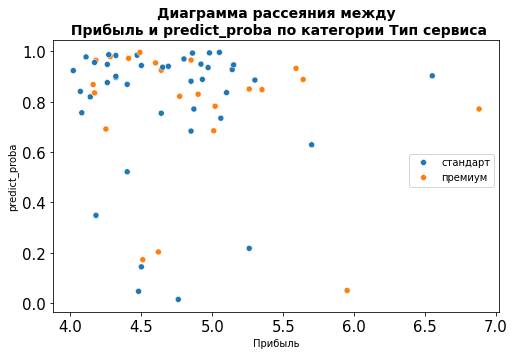

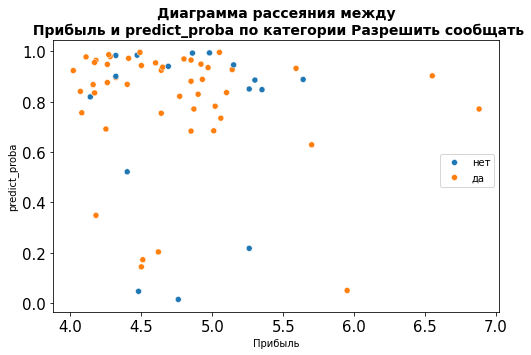

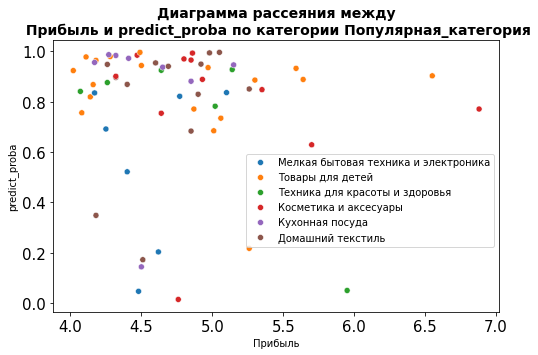

In [ ]:
scat(seg_low, 'predict_proba', 'Прибыль')

In [ ]:
def segment(row, column):
    if row.dtypes[column] == object:
        row[column].value_counts().plot.barh(figsize=(10, 5), grid= True)
        plt.title(column, fontsize=15)
        plt.ylabel('Количество')
        plt.rc('xtick', labelsize= 15 )
        plt.rc('ytick', labelsize= 15 )
        plt.show()
        one = pd.pivot_table(
            row,
            index=column,
            #values = 'id',
            aggfunc='count'
        )
        plt.title(column, fontsize=15)
        row[column].value_counts().plot(
            kind = 'pie',
            figsize=(10,10),
            autopct = '%0.01f%%',
            colors=sns.color_palette('Set2')
        )
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        plt.show()
    else:
        fig, axes = plt.subplots(2, figsize=(15, 15),  sharey='row')
        axes[0].hist(row[column], bins='auto')
        axes[0].grid(True)
        axes[0].set_title(column)
        axes[0].set_ylabel('Количество')
        axes[1].boxplot(data=row, x=column, vert=False, patch_artist=True)
        axes[1].grid(True)
        axes[1].set_xlabel(column)
        plt.show()
        return row[column].describe().T

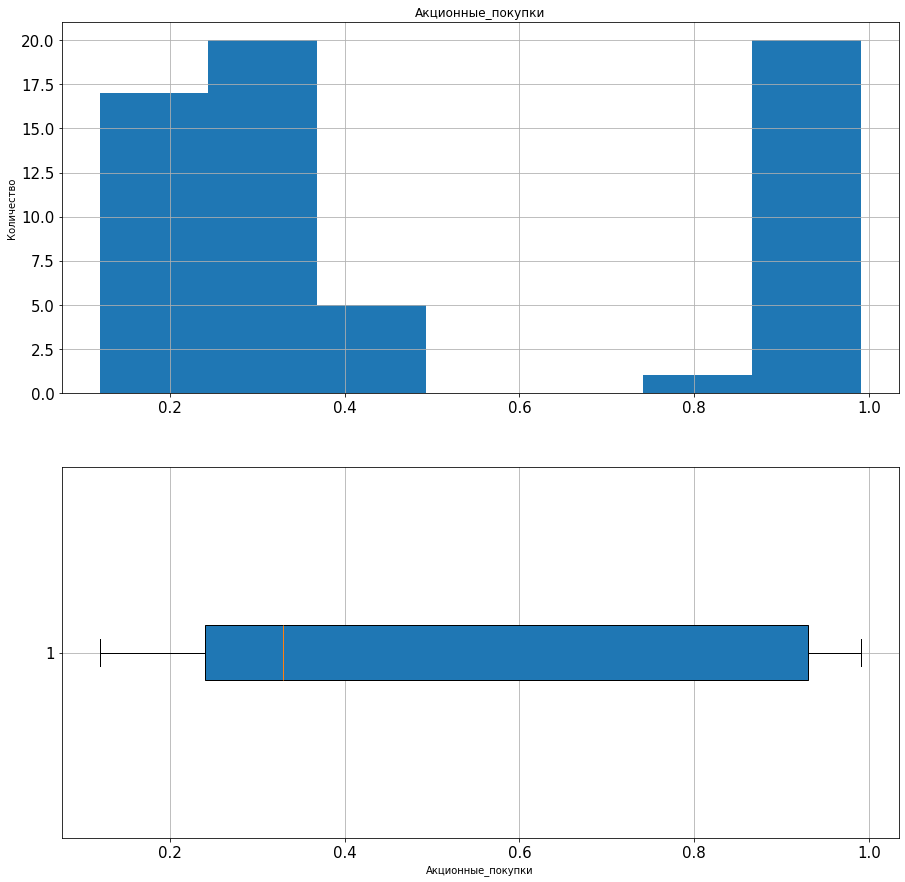

count    63.000000
mean      0.495238
std       0.329197
min       0.120000
25%       0.240000
50%       0.330000
75%       0.930000
max       0.990000
Name: Акционные_покупки, dtype: float64

In [ ]:
segment(seg_low, 'Акционные_покупки')

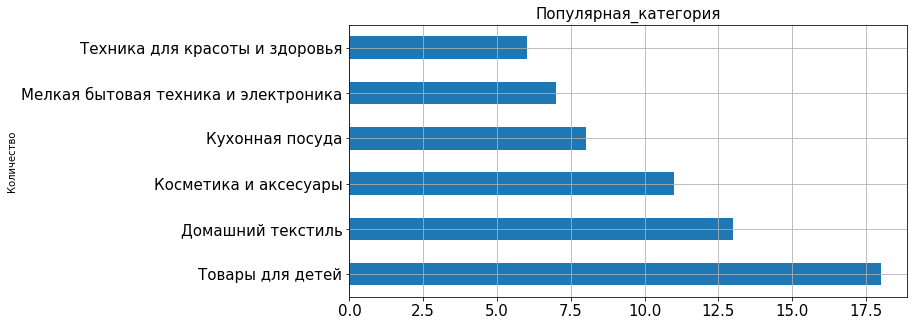

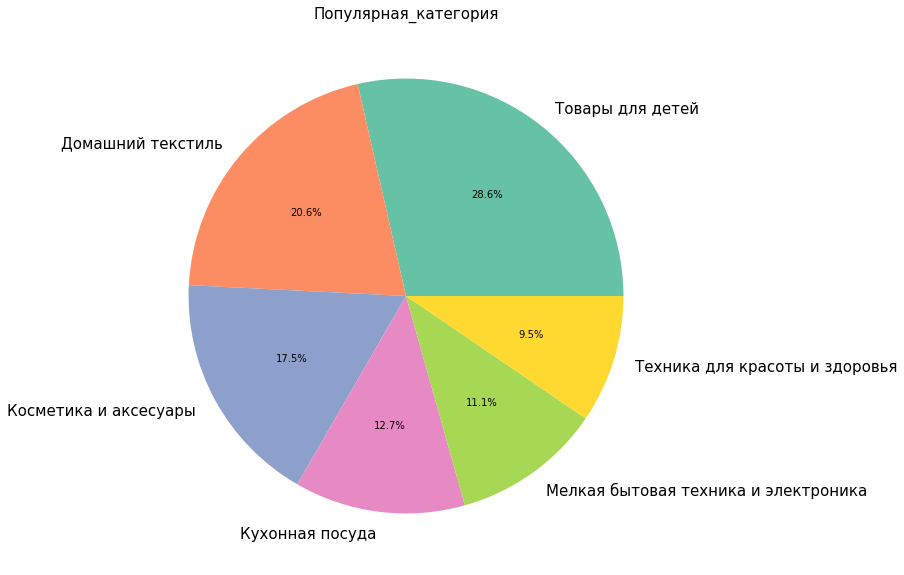

In [ ]:
segment(seg_low, 'Популярная_категория')

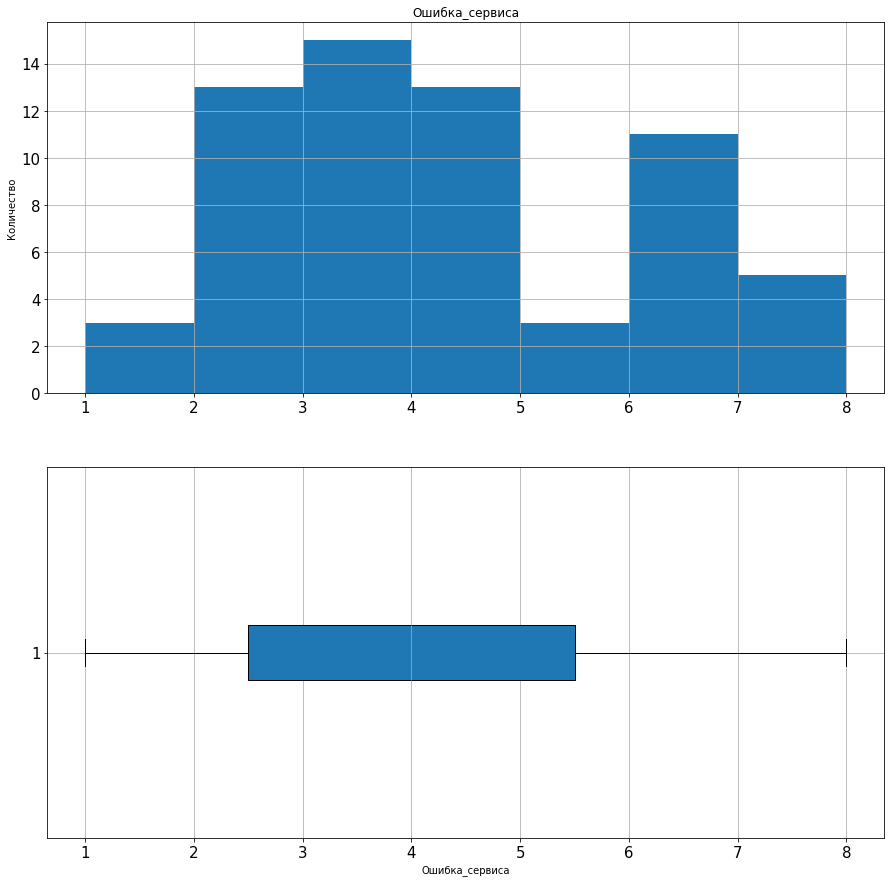

count    63.000000
mean      3.888889
std       1.823778
min       1.000000
25%       2.500000
50%       4.000000
75%       5.500000
max       8.000000
Name: Ошибка_сервиса, dtype: float64

In [ ]:
segment(seg_low, 'Ошибка_сервиса')

Среднее значение в норме в сравнении с общими данными, более высокие значения ошибки сервиза значительно ниже значения по общим данным.

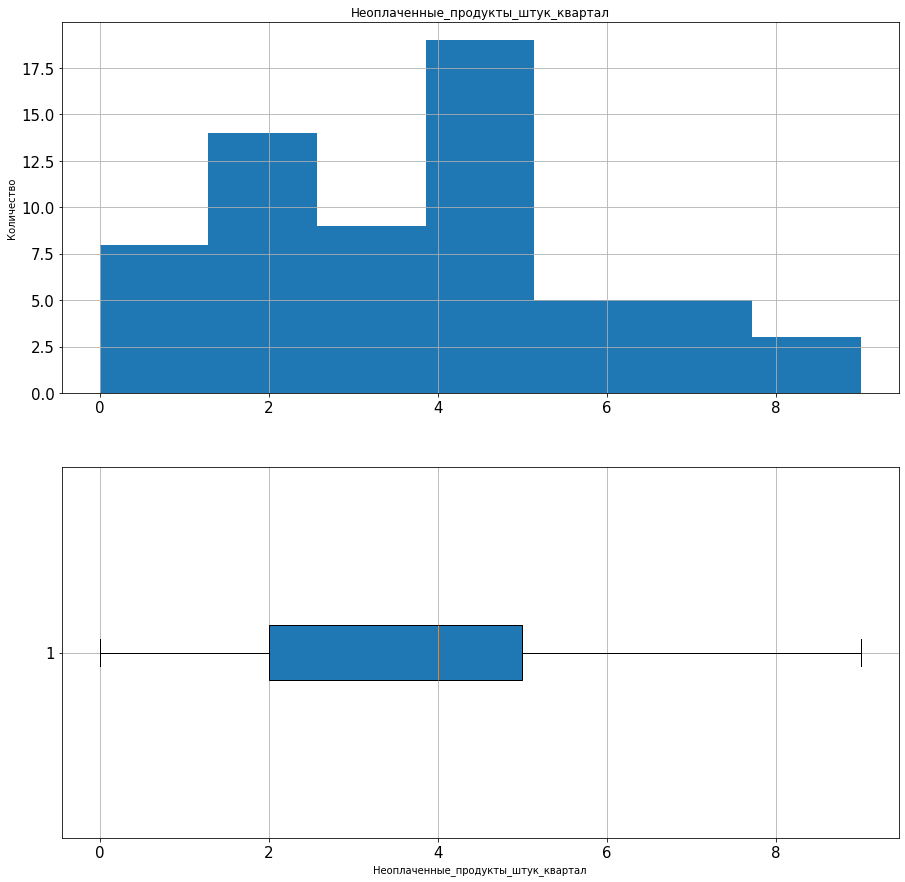

count    63.000000
mean      3.793651
std       2.133895
min       0.000000
25%       2.000000
50%       4.000000
75%       5.000000
max       9.000000
Name: Неоплаченные_продукты_штук_квартал, dtype: float64

In [ ]:
segment(seg_low, 'Неоплаченные_продукты_штук_квартал')

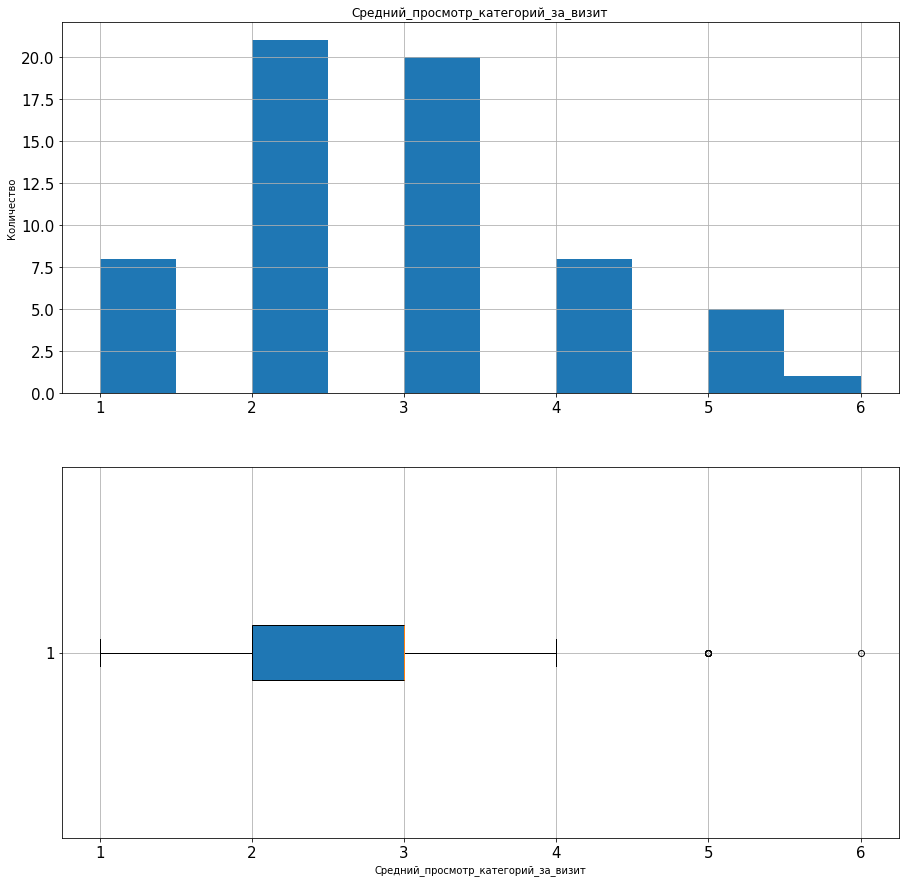

count    63.000000
mean      2.746032
std       1.177316
min       1.000000
25%       2.000000
50%       3.000000
75%       3.000000
max       6.000000
Name: Средний_просмотр_категорий_за_визит, dtype: float64

In [ ]:
segment(seg_low, 'Средний_просмотр_категорий_за_визит')

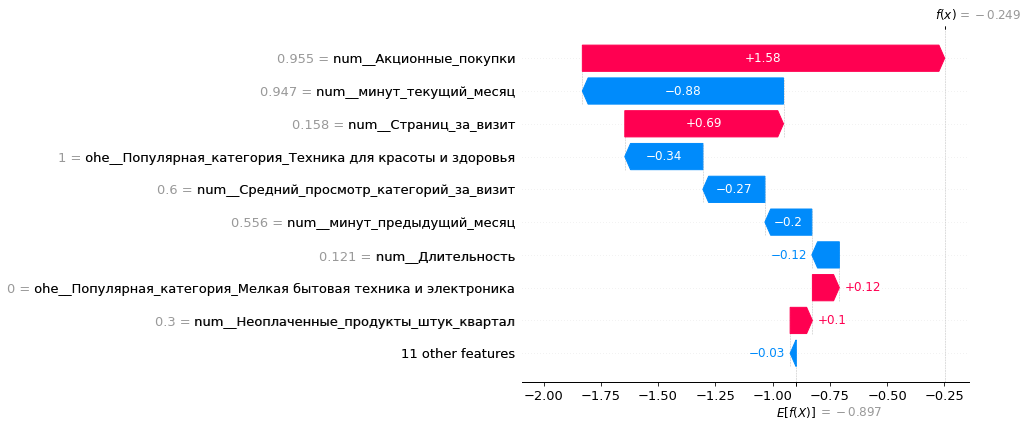

In [ ]:
shap.plots.waterfall(shap_values[19])

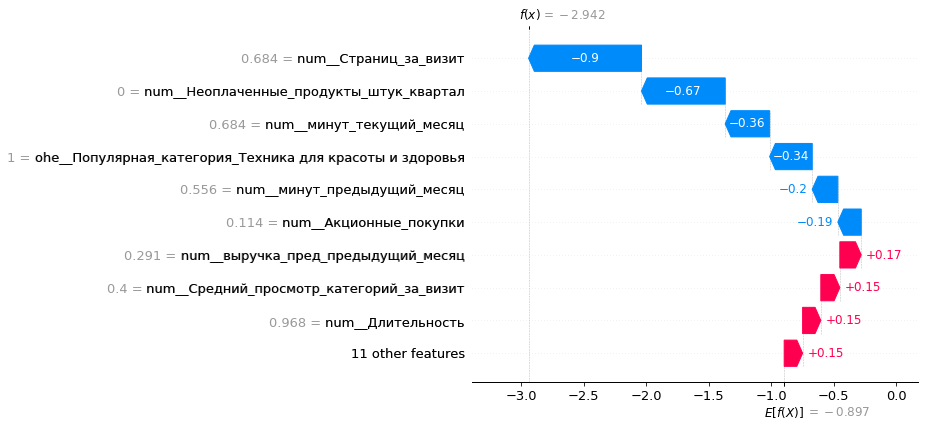

In [ ]:
shap.plots.waterfall(shap_values[320])

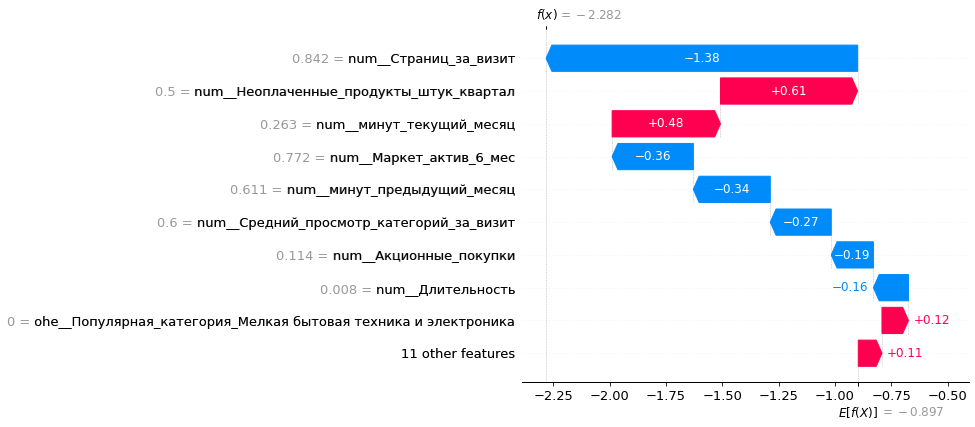

In [ ]:
shap.plots.waterfall(shap_values[11])

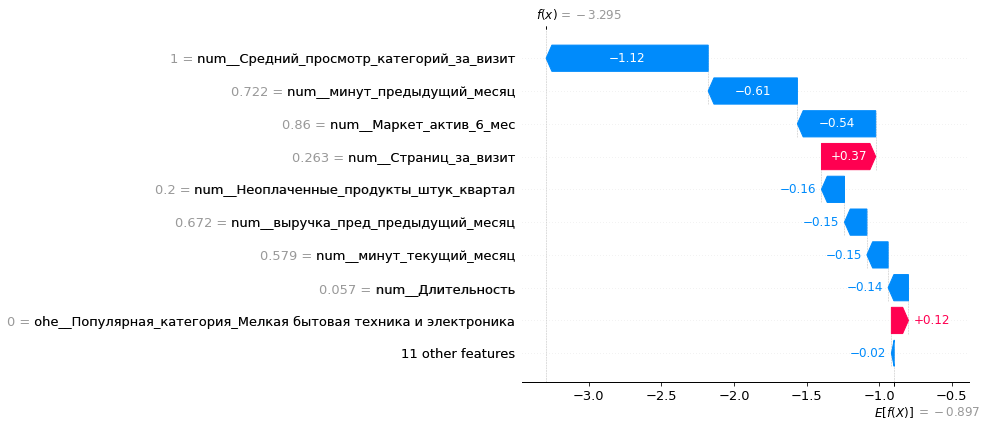

In [ ]:
shap.plots.waterfall(shap_values[5])

### Выводы о сегментах:


Рассмотрена группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

- Наиболее распространённая категория - товары для детей, вероятно зависящая от возраста ребёнка, актуально настроить рекомендации, ведущие приблизительный расчёт предполагаемого возраста ребёнка. Например 5-ти летнему ребёнку уже вряд ли понадобятся такие категории как средства гигиены для малышей.

- Категория домашний текстиль имеет некоторый предел для закупки, стоит рассмотреть персонализированные предложения, такие как средства ухода, предметы интерьера, интерьерные растения.

- Неоплаченные покупки имеют слабый вес и среднее распределение. Выступают вкупе с остальными признаками при определении в сегмент сниженной активности.

- Ошибки сервиса мало влияют на снижение покупательской активности.

- Средний просмотр категорий за визит крайне мал, необходимо настроить персонализированные рекомендации.

## Общий вывод

**В ходе работы над проектом выполнено:**

- Данные прошли проверку и соответствуют описанию. Пропусков в данных не обнаружено.  Разделитель для '/datasets/money.csv', точка с запятой- ;.


- Испаравлены:

  - df_file 'Тип сервиса' - 'стандартт' заменено на 'стандарт'.
  
  - df_market_money 'Период' - препредыдущий_месяц' заменено на 'пред_предыдущий_месяц'.
  
  - df_time 'Период' - 'предыдцщий_месяц' заменено на 'предыдущий_месяц'.
  
  - df_money 'Прибыль' приведен к типу float64.
  
  
- Удален:

    - 1 строка df_market_money 'Выручка' > 20000, id сохранено в переменной drop



- Создана таблица с покупательской активностью по трём месяцам, клиенты с меньшей активностью сохранены в переменной df_to_drop



Для поиска лучшей модели произведён исследовательский и корреляционный анализ данный, далее задействован пайплайн для подбора лучшей модели.

В ходе исследования обнаружено:
- df_market_money 'Выручка' - выбросы - меньше 3350 и больше 6500.
- df_money 'Прибыль' - выбросы-хвосты в значениях меньше 1.2 и больше 6.75
- Акционные_покупки - можно отнести к категориальным признакам при дальнейших усовершенствованиях модели.

При оценке корреляции корреляции по шкале Чеддока:
- Выручка текущий месяц - выручка предыдущий месяц: **высокая связь**.


- Покупательская активность - минут предыдущий месяц: средняя связь~высокая связь.


- Покупательская активность - минут текущий месяц: средняя связь.


- Покупательская активность - страниц за визит: **высокая связь**.


- Покупательская активность - выручка пред предыдущий месяц: средняя связь.


- Покупательская активность - неоплаченные продукты штук квартал: средняя связь.


- Покупательская активность - средний просмотр категорий за визит: средняя связь.


- Покупательская активность - акционные покупки: средняя связь.


- Покупательская активность - маркет актив 6 мес: средняя связь.


**Выделена лучшая модель**


In [ ]:
model

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')


**Мало значимые для модели признаки:**
- Маркет_актив_текущий_месяц

- Разрешить_сообщать

- Маркет_актив_тек_месяц

- Популярная_категория_товары_для_детей

- Популярная_категория_кухонная_посуда

- Тип сервиса

- Выручка_текущий_месяц

- Популярная_категория_Косметика и аксессуары

**Признаки сильнее всего влияющие на целевой признак топ 6:**

- Страниц_за_визит

- Средний_просмотр_категорий_за_визит

- минут_предыдущий_месяц

- Минут_текущий_месяц

- Акционные_покупки

- Неоплаченные_продукты_штук_квартал


**В ходе исследования рассмотрена группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.**

- Наиболее распространённая категория в снижении покупательской активности- товары для детей, вероятно зависящая от возраста ребёнка.

- Вторая по распространенности категория - домашний текстиль.

- Неоплаченные покупки имеют слабый вес и среднее распределение. Выступают вкупе с остальными признаками при определении в сегмент сниженной активности.


- Ошибки сервиса мало влияют на снижение покупательской активности.


- Средний просмотр категорий за визит крайне мал.

**Рекомендации:**

- Для повышения активности пользователей актуально настроить рекомендации, ведущие приблизительный расчёт предполагаемого возраста ребёнка. Например 5-ти летнему ребёнку уже вряд ли понадобятся такие категории как средства гигиены для малышей.


- Пользователи, которые много времени провели онлайн предыдущий месяц могли планировать покупки, таким образом для корректности данных можно также получить информацию о частоте сохранения товаров в избранное.

- Покупательская способность категории домашний текстиль имеет некоторый предел закупки для дома. Стоит рассмотреть персонализированные предложения, такие как средства ухода за текстилем, предметы интерьера, интерьерные растения и прочие близкие по смыслу категории.



- Пользователи, просматривающие много страниц и категорий за визит склонны к большим покупкам. Необходимо хорошо настроить систему предложений похожего товара или товара, косвенно относящегося к просматриваемой категории.



- Устойчивое внимание к платформе достигается простотой использования платформы, информативно будет отследить с какого момента у доли покупателей с постоянным устойчивым спросом происходит спад. Для этого можно отследить падения на датасете за больший период.



- Акционные покупки сильно влияют на продажи, необходимо рассмотреть системы скидок и предложений для просмотренных товаров и категорий. Если клиент вовремя не найдёт искомый товар он может преключиться на другую платформу.